In [11]:
import numpy as np
from matplotlib import pyplot as plt 
from numba import njit, prange
from time import time

To begin we are starting with the assumption that the velocity is linearly related to the GR measurement by the equation
\begin{equation}
v = 5.654 - 0.008GR
\end{equation}

This is a HUGE simplification. but it does allow us to create a PDF where all variables are independant. Our prior marginal model pdf will be constructed using this equation. The returned value will be the center of a gaussian distribution and we will assign a fairly large variance to it because I dont think the assumption holds well outside of sandstone formations. 

In [2]:
@njit
def Gau1d(x, center, std):
    Gau = np.exp(-(x-center)**2/((2*std**2)))
    Const = 1/(std*np.sqrt(2*np.pi))
    Gau = Const*Gau
    #does not garuntee pdf
    return Gau

@njit
def Gau2d(x, centerx, stdx, y, centery, stdy):
    gaux = Gau1d(x, centerx, stdx)
    gauy = Gau1d(y, centery, stdy)
    
    Gau2 = np.outer(gaux, gauy)
    #does not garuntee pdf
    
    return Gau2

def Plot1d(x, fx, label=''):
    plt.plot(x, fx)
    plt.title(label)
    plt.xlabel('velocity (km/s)')
    plt.ylabel("(.)")
    plt.show()
    
def Plot2d(x, y, Gau2, label=''):
    plt.pcolormesh(x, y, Gau2.T, shading='auto')
    plt.colorbar()
    plt.title(label)
    plt.tight_layout()
    plt.show()
    
@njit    
def vGR(GR):
    return 5.654 - 0.008*GR

@njit
def makeSigma(a, b, CALI):
    CREF = 6
    CMAX = 8
    return a + (CALI-CREF)*b/(CMAX-CREF)

@njit
def MakePJoint(prio, margD, xv, px, dx):
    PriorJoint = np.zeros((len(xv), len(px), len(dx)))
    for i in range(len(xv)):
        PriorJoint[i, :, :] = prio[i]*margD
    
    return PriorJoint

@njit
def v2rho(v):
    return 1.74*v**(0.25)

@njit
def rho2phi(rho):
    rhom = 2.71
    rhof = 1
    return (rho - rhom)/(-rhom + rhof)

In [3]:
#read in data

data = np.genfromtxt('Z_GR_NPHI_RHOB_CALI.txt', delimiter=',').T
Z = data[0]
GR = data[1]
NPhi = data[2]
RhoB = data[3]
Cali = data[4]

D = 50

#define value range
xv = np.linspace(2, 7, 520)
#confidence in equation is low so
c = 0.5

#construct a range of values for the density and porosity
px = np.linspace(0, 0.4, 502)
dx = np.linspace(2.2, 3, 504)



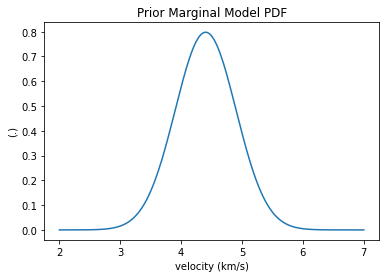

In [4]:
#find center
vbar = vGR(GR[D])

priormarg = Gau1d(xv, vbar, c)

Plot1d(xv, priormarg, 'Prior Marginal Model PDF')

Now we need the marginal data PDF. Obtain this by once again assuming a gaussian distribution for both $\rho$ and $\phi$ where the center is the value of the data at that depth, and the variance is described by
\begin{equation}
\sigma_{\rho} = a_{rho} + \frac{CALI - CREF}{CMAX - CREF}b_{\rho}
\end{equation}
and
\begin{equation}
\sigma_{\phi} = a_{phi} + \frac{CALI - CREF}{CMAX - CREF}b_{\phi}
\end{equation}
where 
$CREF = 6 in \\
CMAX = 8 in \\
a_* = minimum uncertainty \\
b_* = uncertainty scalor$

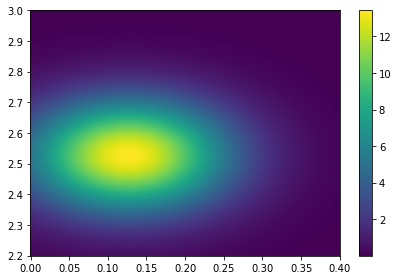

In [5]:
aRho = 0.12
bRho = 0.15
aPhi = 0.08
bPhi = 0.2




#for 1 depth level make the 2d gaussian
sigmap = makeSigma(aPhi, bPhi, Cali[D])
sigmad = makeSigma(aRho, bRho, Cali[D])

MargData = Gau2d(px, NPhi[D], sigmap, dx, RhoB[D], sigmad)
Plot2d(px, dx, MargData)

In [6]:
##Now to combine the two marginals
PriorJoint = MakePJoint(priormarg, MargData, xv, px, dx)
    
#plot3D(xv, px, dx, PriorJoint, jz=10)    

Now we want to cmobine $\rho$ and $\phi$ to construct our Theoretical joint pdf. We will do this by using the relations
\begin{equation}
\rho = 1.74v^{0.25}
\end{equation}
and 
\begin{equation}
rho = (1-\phi)\rho_M + \phi \rho_F
\end{equation}

given that 
$rho_F = 1.00 g/cm^3 \\
rho_M = 2.71 g/cm^3 \\
v_F = 1.50 km/s \\
v_M = 6.64 km/s$ 

we can simplify the second equation to isolate $\phi$

\begin{equation}
\frac{\rho - \rho_M}{\phi} = -\rho_M + \rho_F
\end{equation}
or 
\begin{equation}
\frac{\rho - \rho_M}{-\rho_M + \rho_F} = \phi
\end{equation}

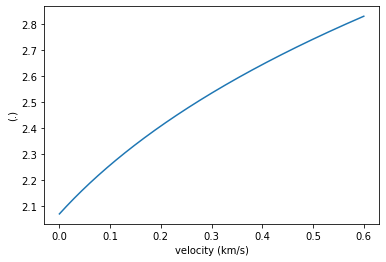

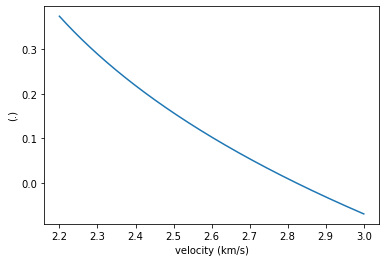

In [7]:


Trho = v2rho(xv)
Tphi = rho2phi(Trho)

Theory = np.zeros((len(xv), len(xv), len(xv)))

pxT = np.linspace(0, 0.6, len(xv))
dxT = np.linspace(2.2, 3, len(xv))

Plot1d(pxT, Trho)
Plot1d(dxT, Tphi)

for i in range(len(xv)):
    Theory[i, :, :] = Gau2d(pxT, Tphi[i], 0.15, dxT, Trho[i], 0.08)
    
Theory /= np.sum(Theory)    

Now all we have to do is take the theory and the prior joints and multiply them together

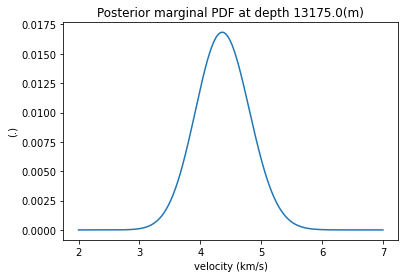

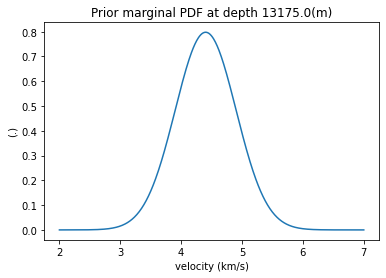

In [8]:
Theory = Theory[0:len(xv), 0:len(px), 0:len(dx)]
Posterior = Theory*PriorJoint

posteriorMarg = np.sum(Posterior, axis=2)
posteriorMarg = np.sum(posteriorMarg, axis=1)
#plot3D(xv, px, dx, Posterior, jz=10)  
Plot1d(xv, posteriorMarg, 'Posterior marginal PDF at depth '+str(Z[D])+ '(m)')
Plot1d(xv, priormarg, 'Prior marginal PDF at depth '+str(Z[D])+ '(m)')

The diferences here are that the center is slightly lower on the prior and the variance is also wider. That makes sense, the inversion should make us more certain. This is promising!

In [26]:
##Loop it 

@njit(parallel=True)
def MakePrior(PriorJoint, priormarg, MargData, xv):
    for i in prange(len(xv)):
        PriorJoint[i, :, :] = priormarg[i]*MargData
        
    return PriorJoint

@njit(parallel=True)
def MakeTheory(pxT, Tphi, dxT, Trho, xv, Gau1, Gau2, Theory):
    for i in prange(len(xv)):
        Gau1 = np.exp(-(pxT-Tphi[i])**2/((2*0.15**2)))
        Const1 = 1/(Tphi[i]*np.sqrt(2*np.pi))
        Gau1 = Const1*Gau1

        Gau2 = np.exp(-(dxT-Trho[i])**2/((2*0.08**2)))
        Const2 = 1/(Trho[i]*np.sqrt(2*np.pi))
        Gau2 = Const2*Gau2
        
        Theory[i, :, :] = np.outer(Gau1, Gau2)
        
    return Theory

#@njit
def Cascade(Z, GR, NPhi, RhoB, Cali, xv, c, px, dx, PriorJoint, Theory, pxT, dxT):
    
    vbar = 5.654 - 0.008*GR

    Gau = np.exp(-(xv-vbar)**2/((2*c**2)))
    Const = 1/(c*np.sqrt(2*np.pi))
    Gau = Const*Gau
    priormarg = Gau
    
    #######################################################
    
    aRho = 0.12
    bRho = 0.15
    aPhi = 0.08
    bPhi = 0.2
    
    CREF = 6
    CMAX = 8
    CALI = Cali

    #for 1 depth level make the 2d gaussian
    sigmap = aPhi + (CALI-CREF)*bPhi/(CMAX-CREF)
    sigmad = aRho + (CALI-CREF)*bRho/(CMAX-CREF)
    

    Gau1 = np.exp(-(px-NPhi)**2/((2*sigmap**2)))
    Const1 = 1/(NPhi*np.sqrt(2*np.pi))
    Gau1 = Const1*Gau1
    
    Gau2 = np.exp(-(dx-RhoB)**2/((2*sigmad**2)))
    Const2 = 1/(RhoB*np.sqrt(2*np.pi))
    Gau2 = Const2*Gau2

    MargData = np.outer(Gau1, Gau2)
    
    #######################################################
    
    
    PriorJoint = MakePrior(PriorJoint, priormarg, MargData, xv)
    
    #######################################################
    
    rhom = 2.71
    rhof = 1
    
    Trho = 1.74*xv**(0.25)
    Tphi = (Trho - rhom)/(-rhom + rhof)
    
    ########################################################
    
    Theory = MakeTheory(pxT, Tphi, dxT, Trho, xv, Gau1, Gau2, Theory)

#     for i in range(len(xv)):
#         Gau1 = np.exp(-(pxT-Tphi[i])**2/((2*0.15**2)))
#         Const1 = 1/(Tphi[i]*np.sqrt(2*np.pi))
#         Gau1 = Const1*Gau1

#         Gau2 = np.exp(-(dxT-Trho[i])**2/((2*0.08**2)))
#         Const2 = 1/(Trho[i]*np.sqrt(2*np.pi))
#         Gau2 = Const2*Gau2
        
#         Theory[i, :, :] = np.outer(Gau1, Gau2)

    Theory /= np.sum(Theory) 
    
    ######################################################
    
    Theory = Theory[0:len(xv), 0:len(px), 0:len(dx)]
    Posterior = Theory*PriorJoint

    posteriorMarg = np.sum(Posterior, axis=2)
    posteriorMarg = np.sum(posteriorMarg, axis=1)

    ######################################################
    
    return posteriorMarg

In [27]:
##Do it!
FullInv = np.zeros((len(Z), len(xv)))
PriorJoint = np.zeros((len(xv), len(px), len(dx)))
Theory = np.zeros((len(xv), len(xv), len(xv)))
pxT = np.linspace(0, 0.6, len(xv))
dxT = np.linspace(2.2, 3, len(xv))

for d in range(len(Z)):
    FullInv[d, :] = Cascade(Z[d], GR[d], NPhi[d], RhoB[d], Cali[d], xv, c, px, dx, PriorJoint, Theory, pxT, dxT)

KeyboardInterrupt: 

In [ ]:
print(FullInv.shape)

Plot2d(range(520), range(3200), FullInv[0:3200, :].T)